# Start The Program

In [12]:
# Data manipulation
import pandas as pd
import numpy as np

from sklearn.ensemble import (VotingClassifier, StackingClassifier, RandomForestClassifier, 
                              GradientBoostingClassifier, AdaBoostClassifier, 
                              ExtraTreesClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Handling imbalanced datasets
from imblearn.over_sampling import SMOTE

# Model selection and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Evaluation metrics
from sklearn.metrics import (confusion_matrix, accuracy_score, f1_score, 
                             recall_score, precision_score, 
                             mean_absolute_error, mean_squared_error, 
                             roc_curve, roc_auc_score)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
data = pd.read_csv('/kaggle/input/avped-dataset/AntiVped.csv')

# Convert non-numeric values to NaN for numeric columns
numeric_columns = ['molecular \nweight', 'Theoretical Pi', 'Extinction \ncoefficient', 
                   'Half life\n(hours)', 'Instability\n index', 'Aliphatic\n index', 
                   'GRAVY', 'Hydrophobic \nresidue :', 'Net charge:', 
                   'Boman Index:\n(Kcal/mol)', 'Protective Antigenic\n Score']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Fill missing values for numerical columns with their mean
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Fill missing values for the categorical column 'Allergenicity' with the most frequent value
data['Allergenicity'] = data['Allergenicity'].fillna(data['Allergenicity'].mode()[0])

# Clean up the column names
data.columns = data.columns.str.replace('\n', '').str.strip()

# Encode the 'Allergenicity' column using LabelEncoder
label_encoder = LabelEncoder()
data['Allergenicity'] = label_encoder.fit_transform(data['Allergenicity'])

# Get unique amino acids in the dataset and create encoding
all_amino_acids = set(''.join(data['Sequence'].tolist()))
amino_acid_to_index = {amino_acid: i for i, amino_acid in enumerate(all_amino_acids)}

# Preprocess sequence data
sequences_encoded = []
for sequence in data['Sequence']:
    encoded_sequence = [amino_acid_to_index[amino_acid] for amino_acid in sequence]
    sequences_encoded.append(encoded_sequence)

# Pad the sequences
max_sequence_length = max(len(seq) for seq in sequences_encoded)
sequences_padded = pad_sequences(sequences_encoded, maxlen=max_sequence_length, padding='post')
data['Sequence_Encoded'] = sequences_padded.tolist()

# Ensure the correct target column name here
y = data['property = 1']  # Replace with the actual name of the target column

# Select the features for X
X = data[['Sequence_Encoded', 'molecular weight', 'Extinction coefficient', 'Theoretical Pi', 
          'Half life(hours)', 'Instability index', 'Aliphatic index', 'GRAVY', 
          'Hydrophobic residue :', 'Net charge:', 'Boman Index:(Kcal/mol)', 
          'Protective Antigenic Score', 'Allergenicity']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert sequence data to numpy arrays
X_train_sequences = np.array(X_train['Sequence_Encoded'].tolist())
X_test_sequences = np.array(X_test['Sequence_Encoded'].tolist())

# Flatten the sequence data
X_train_sequences_flat = X_train_sequences.reshape(X_train_sequences.shape[0], -1)
X_test_sequences_flat = X_test_sequences.reshape(X_test_sequences.shape[0], -1)

# Combine the flattened sequence data with other features
X_train_combined = np.hstack((X_train_sequences_flat, X_train.drop(columns=['Sequence_Encoded']).values))
X_test_combined = np.hstack((X_test_sequences_flat, X_test.drop(columns=['Sequence_Encoded']).values))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined, y_train)


# New ensemble classifiers
ensemble1 = VotingClassifier(estimators=[
    ('gb',GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=10, 
                                       min_samples_split=2, min_samples_leaf=1, 
                                       random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=2, 
                                   min_samples_leaf=1, max_features='sqrt', 
                                   random_state=42)),
    ('et', KNeighborsClassifier(
    n_neighbors=5,         # Number of neighbors to use for knearest neighbors
    weights='uniform',     # Weight function used in prediction ('uniform' or 'distance')
    algorithm='auto',      # Algorithm used to compute the nearest neighbors ('auto', 'ball_tree', 'kd_tree', 'brute')
    leaf_size=30,          # Leaf size passed to the underlying tree-based algorithms
    metric='minkowski'     # Distance metric to use for the tree (default is Minkowski)             # Seed for reproducibility
)),
    ('ada', AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42 ))
], voting='soft')

ensemble2 = StackingClassifier(estimators=[
    ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=10, 
                                       min_samples_split=2, min_samples_leaf=1, 
                                       random_state=42)),
    ('et', KNeighborsClassifier(
    n_neighbors=5,         # Number of neighbors to use for knearest neighbors
    weights='uniform',     # Weight function used in prediction ('uniform' or 'distance')
    algorithm='auto',      # Algorithm used to compute the nearest neighbors ('auto', 'ball_tree', 'kd_tree', 'brute')
    leaf_size=30,          # Leaf size passed to the underlying tree-based algorithms
    metric='minkowski'     # Distance metric to use for the tree (default is Minkowski)
)),
    ('ada', AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42 ))
], final_estimator=RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=2, 
                                   min_samples_leaf=1, max_features='sqrt', 
                                   random_state=42))

ensemble3 = VotingClassifier(estimators=[
    ('xgb', XGBClassifier(use_label_encoder=True, eval_metric='logloss', n_estimators=200, 
                           max_depth=10, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
                           gamma=0, min_child_weight=1)),
    ('brf', BalancedRandomForestClassifier(
        n_estimators=200, criterion='gini', max_depth=10, 
        min_samples_split=2, min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0, bootstrap=True, 
        oob_score=False, random_state=42, 
        verbose=0, class_weight='balanced', 
        min_impurity_decrease=0.0)),
    ('et', KNeighborsClassifier(
    n_neighbors=5,         # Number of neighbors to use for knearest neighbors
    weights='uniform',     # Weight function used in prediction ('uniform' or 'distance')
    algorithm='auto',      # Algorithm used to compute the nearest neighbors ('auto', 'ball_tree', 'kd_tree', 'brute')
    leaf_size=30,          # Leaf size passed to the underlying tree-based algorithms
    metric='minkowski'     # Distance metric to use for the tree (default is Minkowski)
)),
    ('ada', AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42 ))
], voting='soft')

ensemble4 = StackingClassifier(estimators=[
    ('xgb', XGBClassifier(use_label_encoder=True, eval_metric='logloss', n_estimators=200, 
                           max_depth=10, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
                           gamma=0, min_child_weight=1)),
    ('et', KNeighborsClassifier(
    n_neighbors=5,         # Number of neighbors to use for knearest neighbors
    weights='uniform',     # Weight function used in prediction ('uniform' or 'distance')
    algorithm='auto',      # Algorithm used to compute the nearest neighbors ('auto', 'ball_tree', 'kd_tree', 'brute')
    leaf_size=30,          # Leaf size passed to the underlying tree-based algorithms
    metric='minkowski'     # Distance metric to use for the tree (default is Minkowski)
)),
    ('ada', AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42 ))
], final_estimator=BalancedRandomForestClassifier(n_estimators=200, criterion='gini', max_depth=10, 
        min_samples_split=2, min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0, bootstrap=True, 
        oob_score=False, random_state=42, 
        verbose=0, class_weight='balanced', 
        min_impurity_decrease=0.0))

# Add this to your classifiers dictionary
classifiers = {
    'SVM': SVC(probability=True, C=1.0, gamma='scale', 
               shrinking=True, tol=1e-3, cache_size=200, verbose=False, max_iter=-1, 
               decision_function_shape='ovr', break_ties=False),
    
    'Decision Tree': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=5, 
                                            min_samples_split=2, min_samples_leaf=1),
    
    'Extra Tree': ExtraTreesClassifier(n_estimators=100, max_depth=5), 
    
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=2, 
                                   min_samples_leaf=1, random_state=42),
    
    'Logistic Regression': LogisticRegression(penalty='l2', dual=False, tol=0.0001, 
                                             C=1.0, fit_intercept=True, 
                                             intercept_scaling=1, 
                                             max_iter=100,
                                             verbose=0, warm_start=False),
    
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, 
                                       min_samples_split=2, min_samples_leaf=1),
    
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, leaf_size=30),
    
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', 
                                    solver='adam', alpha=0.0001, batch_size='auto', 
                                    learning_rate='constant', learning_rate_init=0.001, 
                                    power_t=0.5, max_iter=200, shuffle=True, 
                                    random_state=None, tol=0.0001, 
                                    verbose=False, warm_start=False, 
                                    momentum=0.9, nesterovs_momentum=True, 
                                    early_stopping=False, validation_fraction=0.1, 
                                    beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    
    'Naive Bayes': GaussianNB(priors=None, var_smoothing=1e-09),
    
    'AdaBoost': AdaBoostClassifier(n_estimators=100),
    
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100),
    
    'Balanced RF': BalancedRandomForestClassifier(
        n_estimators=100, random_state=42),
    
    'Proposed Ensemble 1': ensemble1,
    'Proposed Ensemble 2': ensemble2,
    'Proposed Ensemble 3': ensemble3,
    'Proposed Ensemble 4': ensemble4
}

# Model Selection Based on Result

Model: SVM
Accuracy: 0.7017994858611826
Confusion Matrix:
[[212 133]
 [ 99 334]]
F1 Score: 0.7422222222222222
Recall: 0.7713625866050808
Precision: 0.715203426124197
Mean Absolute Error: 0.2982005141388175
Root Mean Squared Error: 0.5460773884156142
ROC AUC Score: 0.6929276701141345
Specificity: 0.6144927536231884
Matthews Correlation Coefficient: 0.3913266059200814


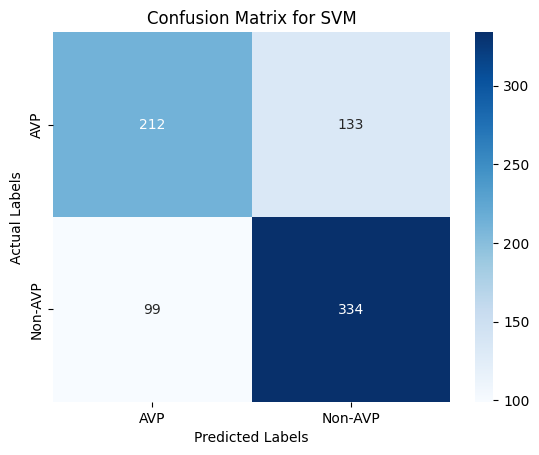

---------------------------------------
Model: Decision Tree
Accuracy: 0.7107969151670951
Confusion Matrix:
[[266  79]
 [146 287]]
F1 Score: 0.7183979974968712
Recall: 0.6628175519630485
Precision: 0.7841530054644809
Mean Absolute Error: 0.2892030848329049
Root Mean Squared Error: 0.5377760545365561
ROC AUC Score: 0.7169160223583358
Specificity: 0.7710144927536232
Matthews Correlation Coefficient: 0.4318033155974003


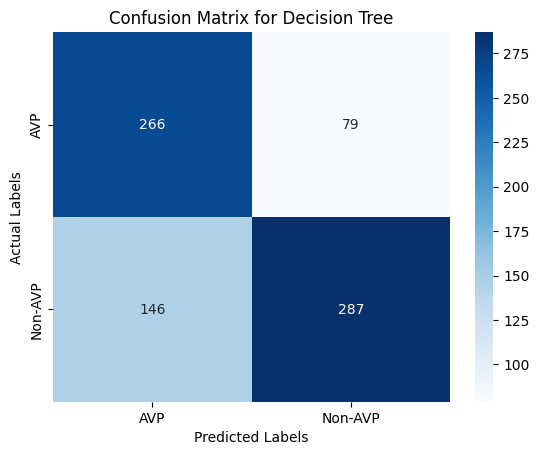

---------------------------------------
Model: Extra Tree
Accuracy: 0.7197943444730077
Confusion Matrix:
[[236 109]
 [109 324]]
F1 Score: 0.7482678983833718
Recall: 0.7482678983833718
Precision: 0.7482678983833718
Mean Absolute Error: 0.2802056555269923
Root Mean Squared Error: 0.5293445527508451
ROC AUC Score: 0.7161629346989323
Specificity: 0.6840579710144927
Matthews Correlation Coefficient: 0.4323258693978646


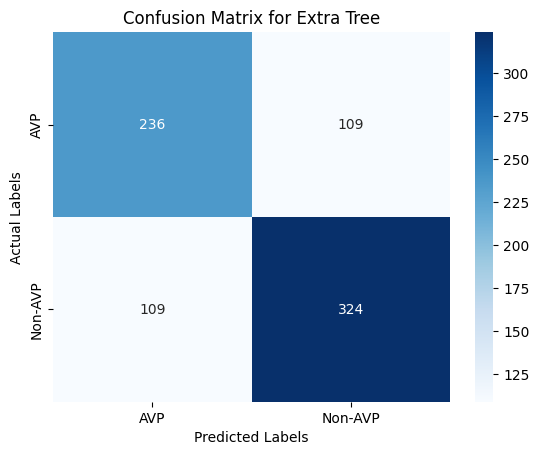

---------------------------------------
Model: Random Forest
Accuracy: 0.7802056555269923
Confusion Matrix:
[[238 107]
 [ 64 369]]
F1 Score: 0.8118811881188118
Recall: 0.8521939953810623
Precision: 0.7752100840336135
Mean Absolute Error: 0.21979434447300772
Root Mean Squared Error: 0.46882229519617313
ROC AUC Score: 0.7710245339224152
Specificity: 0.6898550724637681
Matthews Correlation Coefficient: 0.552567260881734


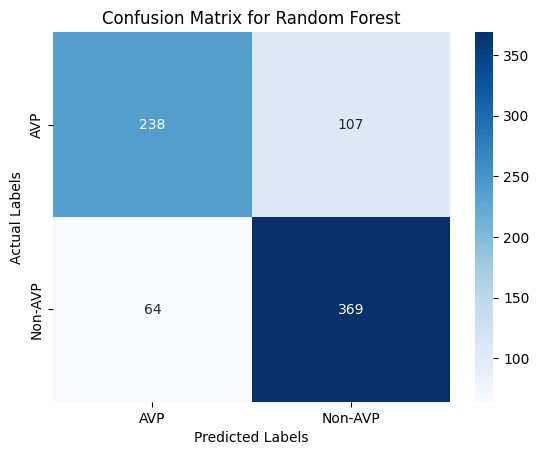

---------------------------------------
Model: Logistic Regression
Accuracy: 0.7043701799485861
Confusion Matrix:
[[230 115]
 [115 318]]
F1 Score: 0.7344110854503464
Recall: 0.7344110854503464
Precision: 0.7344110854503464
Mean Absolute Error: 0.29562982005141386
Root Mean Squared Error: 0.5437185117792237
ROC AUC Score: 0.7005388760585067
Specificity: 0.6666666666666666
Matthews Correlation Coefficient: 0.4010777521170131


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


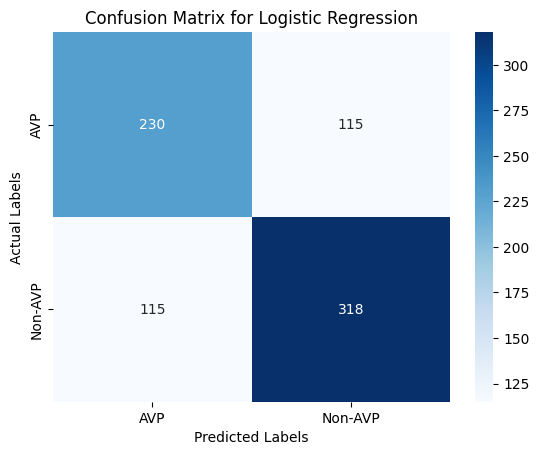

---------------------------------------
Model: Gradient Boosting
Accuracy: 0.8483290488431876
Confusion Matrix:
[[274  71]
 [ 47 386]]
F1 Score: 0.8674157303370786
Recall: 0.8914549653579676
Precision: 0.8446389496717724
Mean Absolute Error: 0.15167095115681234
Root Mean Squared Error: 0.3894495489236216
ROC AUC Score: 0.8428289319543463
Specificity: 0.7942028985507247
Matthews Correlation Coefficient: 0.6919111685016217


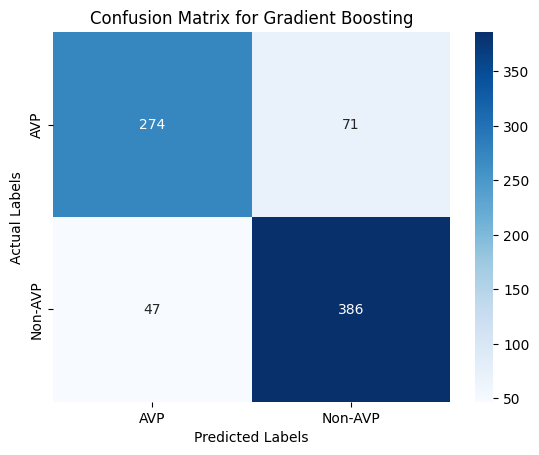

---------------------------------------
Model: K-Nearest Neighbors
Accuracy: 0.7429305912596401
Confusion Matrix:
[[260  85]
 [115 318]]
F1 Score: 0.7607655502392344
Recall: 0.7344110854503464
Precision: 0.7890818858560794
Mean Absolute Error: 0.2570694087403599
Root Mean Squared Error: 0.5070201265633938
ROC AUC Score: 0.7440171369280718
Specificity: 0.7536231884057971
Matthews Correlation Coefficient: 0.48521661265280003


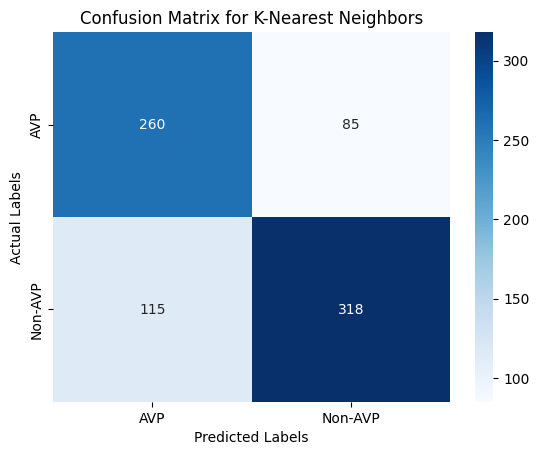

---------------------------------------
Model: Neural Network
Accuracy: 0.6928020565552699
Confusion Matrix:
[[133 212]
 [ 27 406]]
F1 Score: 0.7725975261655567
Recall: 0.9376443418013857
Precision: 0.656957928802589
Mean Absolute Error: 0.30719794344473006
Root Mean Squared Error: 0.5542544031802815
ROC AUC Score: 0.6615757940890986
Specificity: 0.3855072463768116
Matthews Correlation Coefficient: 0.3971966358791888


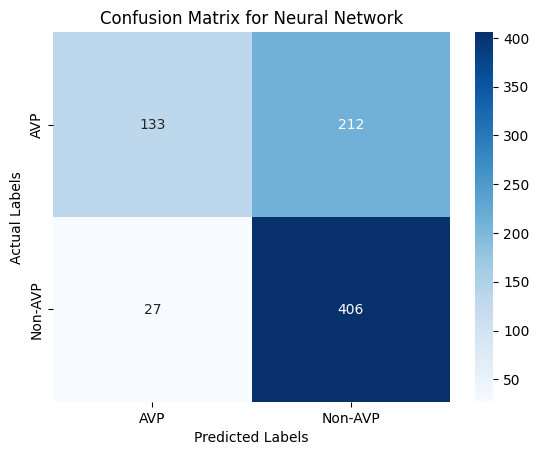

---------------------------------------
Model: Naive Bayes
Accuracy: 0.6709511568123393
Confusion Matrix:
[[162 183]
 [ 73 360]]
F1 Score: 0.7377049180327869
Recall: 0.8314087759815243
Precision: 0.6629834254143646
Mean Absolute Error: 0.32904884318766064
Root Mean Squared Error: 0.5736277915056598
ROC AUC Score: 0.6504869966864143
Specificity: 0.46956521739130436
Matthews Correlation Coefficient: 0.3256481538129483


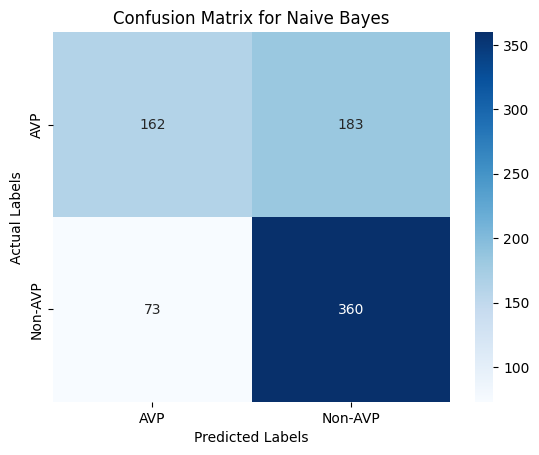

---------------------------------------
Model: AdaBoost
Accuracy: 0.7789203084832905
Confusion Matrix:
[[258  87]
 [ 85 348]]
F1 Score: 0.8018433179723503
Recall: 0.8036951501154734
Precision: 0.8
Mean Absolute Error: 0.2210796915167095
Root Mean Squared Error: 0.47019112232868615
ROC AUC Score: 0.7757606185359975
Specificity: 0.7478260869565218
Matthews Correlation Coefficient: 0.5518538127225643


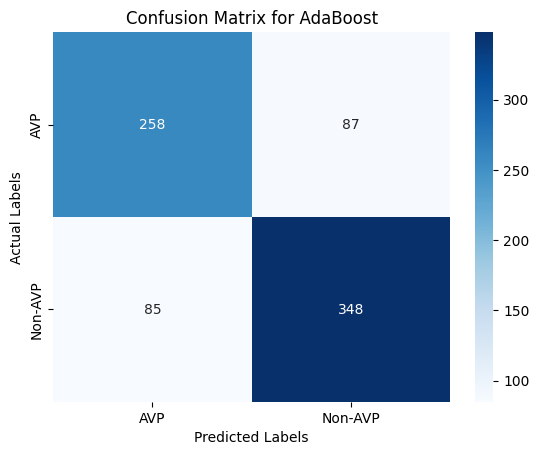

---------------------------------------
Model: XGBoost
Accuracy: 0.8534704370179949
Confusion Matrix:
[[278  67]
 [ 47 386]]
F1 Score: 0.871331828442438
Recall: 0.8914549653579676
Precision: 0.8520971302428256
Mean Absolute Error: 0.14652956298200515
Root Mean Squared Error: 0.3827918010903645
ROC AUC Score: 0.8486260334036215
Specificity: 0.8057971014492754
Matthews Correlation Coefficient: 0.7023482820987956


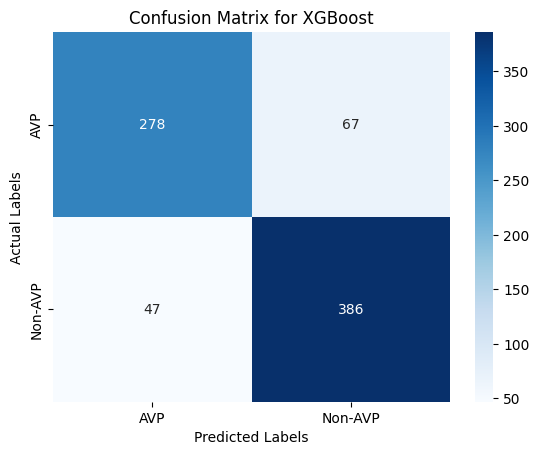

---------------------------------------
Model: Balanced RF


/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Accuracy: 0.8444730077120822
Confusion Matrix:
[[274  71]
 [ 50 383]]
F1 Score: 0.8635851183765502
Recall: 0.8845265588914549
Precision: 0.8436123348017621
Mean Absolute Error: 0.15552699228791775
Root Mean Squared Error: 0.3943691066601411
ROC AUC Score: 0.8393647287210898
Specificity: 0.7942028985507247
Matthews Correlation Coefficient: 0.6839900160594244


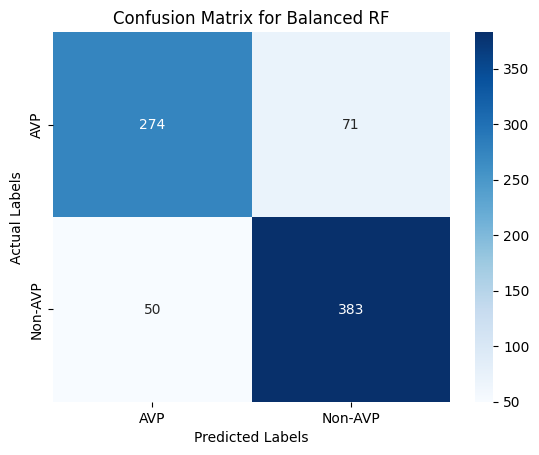

---------------------------------------
Model: Proposed Ensemble 1
Accuracy: 0.8457583547557841
Confusion Matrix:
[[282  63]
 [ 57 376]]
F1 Score: 0.8623853211009174
Recall: 0.8683602771362586
Precision: 0.856492027334852
Mean Absolute Error: 0.15424164524421594
Root Mean Squared Error: 0.39273610127440023
ROC AUC Score: 0.8428757907420423
Specificity: 0.8173913043478261
Matthews Correlation Coefficient: 0.6870497791390364


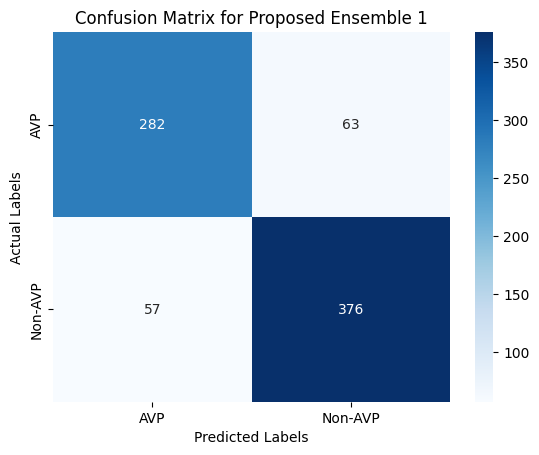

---------------------------------------
Model: Proposed Ensemble 2
Accuracy: 0.8611825192802056
Confusion Matrix:
[[290  55]
 [ 53 380]]
F1 Score: 0.8755760368663595
Recall: 0.8775981524249422
Precision: 0.8735632183908046
Mean Absolute Error: 0.13881748071979436
Root Mean Squared Error: 0.3725821798204986
ROC AUC Score: 0.8590889312849348
Specificity: 0.8405797101449275
Matthews Correlation Coefficient: 0.7186109346871586


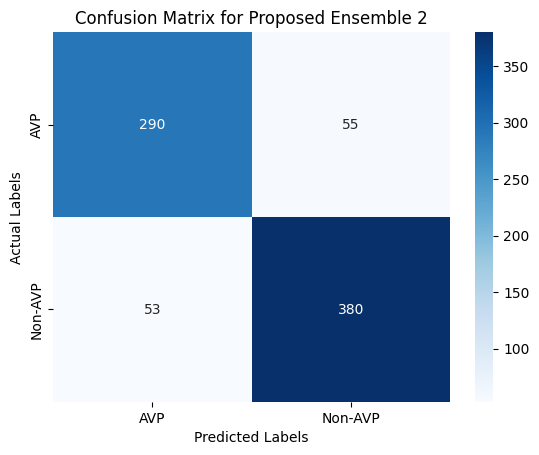

---------------------------------------
Model: Proposed Ensemble 3


/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Accuracy: 0.8406169665809768
Confusion Matrix:
[[276  69]
 [ 55 378]]
F1 Score: 0.8590909090909091
Recall: 0.8729792147806005
Precision: 0.8456375838926175
Mean Absolute Error: 0.15938303341902313
Root Mean Squared Error: 0.3992280468842628
ROC AUC Score: 0.8364896073903002
Specificity: 0.8
Matthews Correlation Coefficient: 0.6762190298804425


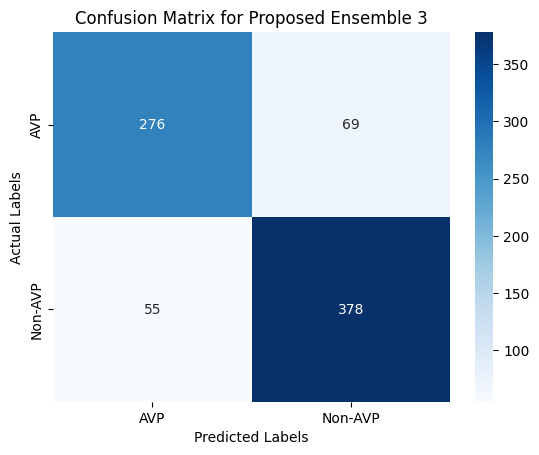

---------------------------------------
Model: Proposed Ensemble 4


/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Accuracy: 0.8598971722365039
Confusion Matrix:
[[286  59]
 [ 50 383]]
F1 Score: 0.8754285714285714
Recall: 0.8845265588914549
Precision: 0.8665158371040724
Mean Absolute Error: 0.14010282776349614
Root Mean Squared Error: 0.37430312283428274
ROC AUC Score: 0.8567560330689159
Specificity: 0.8289855072463768
Matthews Correlation Coefficient: 0.7156061168540689


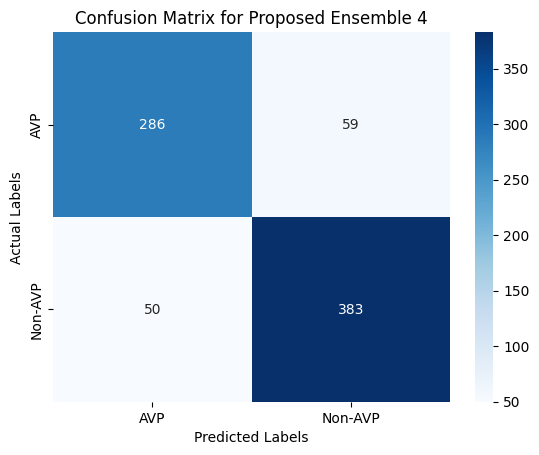

---------------------------------------


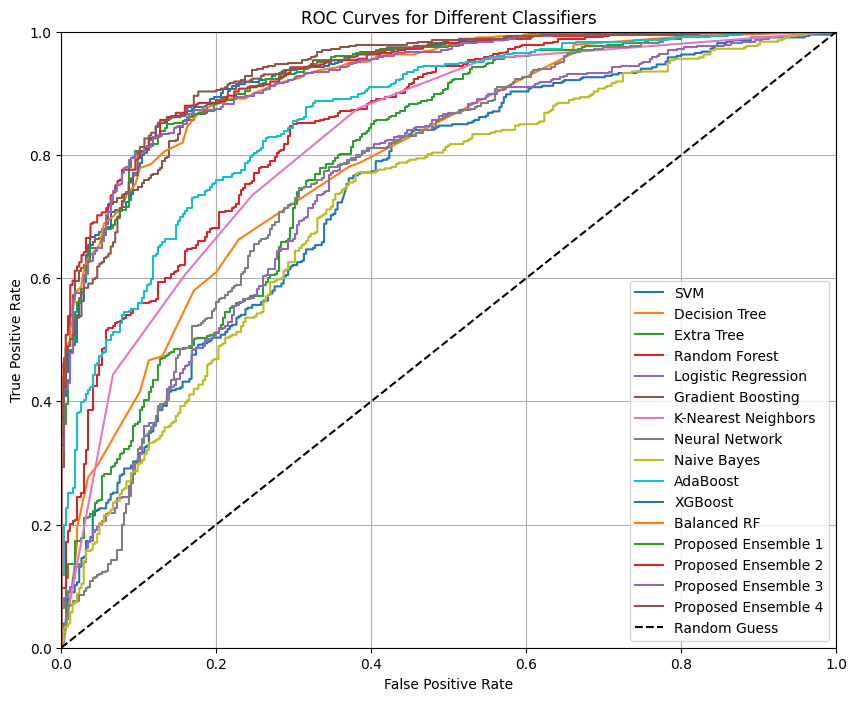

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, mean_absolute_error, mean_squared_error, roc_auc_score, roc_curve

# Initialize lists for ROC data
roc_data = {}

# Train and evaluate each classifier
for name, classifier in classifiers.items():
    print(f"Model: {name}")
    
    classifier.fit(X_train_balanced, y_train_balanced)
    y_pred = classifier.predict(X_test_combined)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix:\n{cm}")

    # Calculate F1 score, precision, recall, etc.
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Calculate Specificity
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Calculate Matthews Correlation Coefficient
    mcc = (tp * tn - fp * fn) / ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5 if (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) > 0 else 0

    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"ROC AUC Score: {roc_auc}")
    print(f"Specificity: {specificity}")
    print(f"Matthews Correlation Coefficient: {mcc}")

    # Create and save a heatmap of the confusion matrix
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=["AVP", "Non-AVP"], yticklabels=["AVP", "Non-AVP"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title(f"Confusion Matrix for {name}")
    
    # Save the confusion matrix as an image file
    plt.savefig(f'Confusion_{name}.png', format='png', dpi=600, bbox_inches="tight")
    plt.show()  # Close the plot to avoid display

    # Store ROC curve data
    y_prob = classifier.predict_proba(X_test_combined)[:, 1]  # Probability estimates for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Ensure ROC curve starts at (0, 0)
    fpr = np.concatenate([[0], fpr])  # Add 0 at the start
    tpr = np.concatenate([[0], tpr])  # Add 0 at the start
    roc_data[name] = (fpr, tpr, roc_auc)

    print("---------------------------------------")

# Plot all ROC curves in a single plot
Rocsaved = plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name}')

# Plot the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Set the axis limits to start from (0, 0)
plt.xlim(0, 1)
plt.ylim(0, 1)

# Set the labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend(loc='lower right')
plt.grid()

# Save the ROC curve figure
Rocsaved.savefig('ROC Curve.png', format='png', dpi=600, bbox_inches="tight")
plt.show()

# Li et al. 2020 (DeepAVP)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Conv1D, Flatten, Concatenate
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE

# Load the CSV file
data = pd.read_csv('/kaggle/input/avped-dataset/AntiVped.csv')
data.head()

# Data preprocessing
# Convert non-numeric values to NaN for numeric columns
numeric_columns = ['molecular \nweight', 'Theoretical Pi', 'Extinction \ncoefficient', 
                   'Half life\n(hours)', 'Instability\n index', 'Aliphatic\n index', 
                   'GRAVY', 'Hydrophobic \nresidue :', 'Net charge:', 
                   'Boman Index:\n(Kcal/mol)', 'Protective Antigenic\n Score']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Fill missing values
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())
data['Allergenicity'] = data['Allergenicity'].fillna(data['Allergenicity'].mode()[0])

data.columns = data.columns.str.replace('\n', '').str.strip()

label_encoder = LabelEncoder()
data['Allergenicity'] = label_encoder.fit_transform(data['Allergenicity'])

# Encode sequences
all_amino_acids = set(''.join(data['Sequence'].tolist()))
amino_acid_to_index = {amino_acid: i for i, amino_acid in enumerate(all_amino_acids)}

sequences_encoded = []
for sequence in data['Sequence']:
    encoded_sequence = [amino_acid_to_index[amino_acid] for amino_acid in sequence]
    sequences_encoded.append(encoded_sequence)

# Pad the sequences
max_sequence_length = max(len(seq) for seq in sequences_encoded)
sequences_padded = pad_sequences(sequences_encoded, maxlen=max_sequence_length, padding='post')
data['Sequence_Encoded'] = sequences_padded.tolist()

# Ensure the correct target column name here
y = data['property = 1']  # Replace with the actual name of the target column

# Select features
X = data[['Sequence_Encoded', 'molecular weight', 'Extinction coefficient', 'Theoretical Pi', 
          'Half life(hours)', 'Instability index', 'Aliphatic index', 'GRAVY', 
          'Hydrophobic residue :', 'Net charge:', 'Boman Index:(Kcal/mol)', 
          'Protective Antigenic Score', 'Allergenicity']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert sequence data to numpy arrays
X_train_sequences = np.array(X_train['Sequence_Encoded'].tolist())
X_test_sequences = np.array(X_test['Sequence_Encoded'].tolist())

# Reshape to fit LSTM input shape
X_train_sequences_reshaped = X_train_sequences.reshape(X_train_sequences.shape[0], max_sequence_length, 1)
X_test_sequences_reshaped = X_test_sequences.reshape(X_test_sequences.shape[0], max_sequence_length, 1)

# Combine additional features
X_train_combined = np.hstack((X_train_sequences.reshape(X_train_sequences.shape[0], -1), 
                               X_train.drop(columns=['Sequence_Encoded']).values))
X_test_combined = np.hstack((X_test_sequences.reshape(X_test_sequences.shape[0], -1), 
                              X_test.drop(columns=['Sequence_Encoded']).values))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined, y_train)

# Split the balanced dataset back to sequence and other features
X_train_balanced_sequences = X_train_balanced[:, :max_sequence_length]  # Sequence part
X_train_balanced_features = X_train_balanced[:, max_sequence_length:]      # Other features

# Reshape the sequence data for LSTM input
X_train_balanced_reshaped = X_train_balanced_sequences.reshape(-1, max_sequence_length, 1)

# Convert target variable to categorical if it's a classification problem
num_classes = len(np.unique(y))
y_train_balanced_categorical = to_categorical(y_train_balanced, num_classes=num_classes)

# Create the model
def build_hybrid_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # LSTM Channel
    lstm_out = LSTM(64)(inputs)
    lstm_out = Dropout(0.5)(lstm_out)
    
    # CNN Channel
    conv_out = Conv1D(32, kernel_size=3, activation='relu')(inputs)
    conv_out = Dropout(0.5)(conv_out)
    conv_out = Flatten()(conv_out)
    
    # Concatenate both channels
    combined = Concatenate()([lstm_out, conv_out])
    dense_out = Dense(64, activation='relu')(combined)
    output = Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')(dense_out)
    
    # Model setup
    model = Model(inputs, output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Set learning rate here
    model.compile(optimizer=optimizer, loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy', metrics=['accuracy'])
    return model

DeepAVP = build_hybrid_model((max_sequence_length, 1))

# Train the model
DeepAVP.fit(X_train_balanced_reshaped, y_train_balanced_categorical, 
          epochs=100, batch_size=32, validation_split=0.3)

# Evaluate the model
X_test_sequences_reshaped = X_test_sequences.reshape(X_test_sequences.shape[0], max_sequence_length, 1)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

DeepAVP_loss, DeepAVP_accuracy = DeepAVP.evaluate(X_test_sequences_reshaped, y_test_categorical)
print(f'DeepAVP Accuracy: {DeepAVP_accuracy:.4f}')

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.6139 - loss: 1.0973 - val_accuracy: 0.6192 - val_loss: 0.6226
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6671 - loss: 0.6370 - val_accuracy: 0.6343 - val_loss: 0.6193
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6885 - loss: 0.6031 - val_accuracy: 0.6475 - val_loss: 0.6148
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6710 - loss: 0.6032 - val_accuracy: 0.6657 - val_loss: 0.5869
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6956 - loss: 0.5861 - val_accuracy: 0.6980 - val_loss: 0.5759
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7033 - loss: 0.5702 - val_accuracy: 0.6970 - val_loss: 0.5630
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7204 - loss: 0.5385 - val_accuracy: 0.7020 - val_loss: 0.5556
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7207 - loss: 0.5359 - val_accuracy: 0.

# Singh et al. 2020 (Deep-AVPiden)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Add, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE

# Load the CSV file
data = pd.read_csv('/kaggle/input/avped-dataset/AntiVped.csv')
data.head()

# Data preprocessing
# Convert non-numeric values to NaN for numeric columns
numeric_columns = ['molecular \nweight', 'Theoretical Pi', 'Extinction \ncoefficient', 
                   'Half life\n(hours)', 'Instability\n index', 'Aliphatic\n index', 
                   'GRAVY', 'Hydrophobic \nresidue :', 'Net charge:', 
                   'Boman Index:\n(Kcal/mol)', 'Protective Antigenic\n Score']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Fill missing values
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())
data['Allergenicity'] = data['Allergenicity'].fillna(data['Allergenicity'].mode()[0])

data.columns = data.columns.str.replace('\n', '').str.strip()

label_encoder = LabelEncoder()
data['Allergenicity'] = label_encoder.fit_transform(data['Allergenicity'])

# Encode sequences
all_amino_acids = set(''.join(data['Sequence'].tolist()))
amino_acid_to_index = {amino_acid: i for i, amino_acid in enumerate(all_amino_acids)}

sequences_encoded = []
for sequence in data['Sequence']:
    encoded_sequence = [amino_acid_to_index[amino_acid] for amino_acid in sequence]
    sequences_encoded.append(encoded_sequence)

# Pad the sequences
max_sequence_length = max(len(seq) for seq in sequences_encoded)
sequences_padded = pad_sequences(sequences_encoded, maxlen=max_sequence_length, padding='post')
data['Sequence_Encoded'] = sequences_padded.tolist()

# Ensure the correct target column name here
y = data['property = 1'] 

# Select features
X = data[['Sequence_Encoded', 'molecular weight', 'Extinction coefficient', 'Theoretical Pi', 
          'Half life(hours)', 'Instability index', 'Aliphatic index', 'GRAVY', 
          'Hydrophobic residue :', 'Net charge:', 'Boman Index:(Kcal/mol)', 
          'Protective Antigenic Score', 'Allergenicity']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert sequence data to numpy arrays
X_train_sequences = np.array(X_train['Sequence_Encoded'].tolist())
X_test_sequences = np.array(X_test['Sequence_Encoded'].tolist())

# Reshape to fit input shape
X_train_sequences_reshaped = X_train_sequences.reshape(X_train_sequences.shape[0], max_sequence_length, 1)
X_test_sequences_reshaped = X_test_sequences.reshape(X_test_sequences.shape[0], max_sequence_length, 1)

# Combine additional features
X_train_combined = np.hstack((X_train_sequences.reshape(X_train_sequences.shape[0], -1), 
                               X_train.drop(columns=['Sequence_Encoded']).values))
X_test_combined = np.hstack((X_test_sequences.reshape(X_test_sequences.shape[0], -1), 
                              X_test.drop(columns=['Sequence_Encoded']).values))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined, y_train)

# Split the balanced dataset back to sequence and other features
X_train_balanced_sequences = X_train_balanced[:, :max_sequence_length]  # Sequence part

# Reshape the sequence data for TCN input
X_train_balanced_reshaped = X_train_balanced_sequences.reshape(-1, max_sequence_length, 1)

# Define Temporal Convolutional Block
def tcn_block(inputs, filters, kernel_size, dilation_rate):
    x = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding="causal", activation="relu")(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding="causal", activation="relu")(x)
    x = BatchNormalization()(x)
    return Add()([inputs, x])  # Residual connection

# Build Model
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = tcn_block(inputs, filters=32, kernel_size=3, dilation_rate=1)
    x = tcn_block(x, filters=32, kernel_size=3, dilation_rate=2)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation="sigmoid")(x)  # Single output for binary classification
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Build and train the model
Deep_AVPiden = build_model((max_sequence_length, 1))

# Train the model
Deep_AVPiden.fit(X_train_balanced_reshaped, y_train_balanced, 
          epochs=100, batch_size=32, validation_split=0.3)

# Evaluate the model
X_test_sequences_reshaped = X_test_sequences.reshape(X_test_sequences.shape[0], max_sequence_length, 1)

Deep_AVPiden_loss, Deep_AVPiden_accuracy = Deep_AVPiden.evaluate(X_test_sequences_reshaped, y_test)
print(f'Deep_AVPiden Accuracy: {Deep_AVPiden_accuracy:.4f}')

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5635 - loss: 1.7420 - val_accuracy: 0.6444 - val_loss: 0.6391
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6386 - loss: 0.6743 - val_accuracy: 0.6535 - val_loss: 0.6213
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6362 - loss: 0.6358 - val_accuracy: 0.5970 - val_loss: 0.6700
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6661 - loss: 0.6244 - val_accuracy: 0.6444 - val_loss: 0.6610
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6444 - loss: 0.6342 - val_accuracy: 0.6374 - val_loss: 0.6636
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6581 - loss: 0.6285 - val_accuracy: 0.6475 - val_loss: 0.6184
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6699 - loss: 0.6115 - val_accuracy: 0.6596 - val_loss: 0.6130
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6528 - loss: 0.6255 - val_accuracy: 0.

# Sharma et al. 2021 (Deep_AVPpred)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D, Input, BatchNormalization, Add
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the CSV file
data = pd.read_csv('/kaggle/input/avped-dataset/AntiVped.csv')
data.head()

# Data preprocessing
# Convert non-numeric values to NaN for numeric columns
numeric_columns = ['molecular \nweight', 'Theoretical Pi', 'Extinction \ncoefficient', 
                   'Half life\n(hours)', 'Instability\n index', 'Aliphatic\n index', 
                   'GRAVY', 'Hydrophobic \nresidue :', 'Net charge:', 
                   'Boman Index:\n(Kcal/mol)', 'Protective Antigenic\n Score']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Fill missing values
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())
data['Allergenicity'] = data['Allergenicity'].fillna(data['Allergenicity'].mode()[0])

data.columns = data.columns.str.replace('\n', '').str.strip()

label_encoder = LabelEncoder()
data['Allergenicity'] = label_encoder.fit_transform(data['Allergenicity'])

# Encode sequences
all_amino_acids = set(''.join(data['Sequence'].tolist()))
amino_acid_to_index = {amino_acid: i for i, amino_acid in enumerate(all_amino_acids)}

sequences_encoded = []
for sequence in data['Sequence']:
    encoded_sequence = [amino_acid_to_index[amino_acid] for amino_acid in sequence]
    sequences_encoded.append(encoded_sequence)

# Pad the sequences
max_sequence_length = max(len(seq) for seq in sequences_encoded)
sequences_padded = pad_sequences(sequences_encoded, maxlen=max_sequence_length, padding='post')
data['Sequence_Encoded'] = sequences_padded.tolist()

# Ensure the correct target column name here
y = data['property = 1']

# Select features
X = data[['Sequence_Encoded', 'molecular weight', 'Extinction coefficient', 'Theoretical Pi', 
          'Half life(hours)', 'Instability index', 'Aliphatic index', 'GRAVY', 
          'Hydrophobic residue :', 'Net charge:', 'Boman Index:(Kcal/mol)', 
          'Protective Antigenic Score', 'Allergenicity']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert sequence data to numpy arrays
X_train_sequences = np.array(X_train['Sequence_Encoded'].tolist())
X_test_sequences = np.array(X_test['Sequence_Encoded'].tolist())

# Flatten the sequence data
X_train_sequences_flat = X_train_sequences.reshape(X_train_sequences.shape[0], -1)
X_test_sequences_flat = X_test_sequences.reshape(X_test_sequences.shape[0], -1)

# Combine the flattened sequence data with other features
X_train_combined = np.hstack((X_train_sequences_flat, X_train.drop(columns=['Sequence_Encoded']).values))
X_test_combined = np.hstack((X_test_sequences_flat, X_test.drop(columns=['Sequence_Encoded']).values))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined, y_train)

# Convert target variable to categorical if it's a classification problem
num_classes = len(np.unique(y))  # Adjust based on your target classes
y_train_balanced_categorical = to_categorical(y_train_balanced, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Reshape the balanced training data to include only the sequence part
X_train_sequences_balanced = X_train_balanced[:, :max_sequence_length]  # Select only the sequence part
X_test_sequences = X_test_combined[:, :max_sequence_length]  # Same for test

# Reshape to fit the model input shape
X_train_balanced_reshaped = X_train_sequences_balanced.reshape(X_train_sequences_balanced.shape[0], max_sequence_length, 1)
X_test_reshaped = X_test_sequences.reshape(X_test_sequences.shape[0], max_sequence_length, 1)

# Define a ResNet-like architecture for 1D data
def resnet_block(input_tensor, filters):
    # First convolution block
    x = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv1D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Adjust input tensor shape for residual connection
    if input_tensor.shape[-1] != filters:
        input_tensor = Conv1D(filters, kernel_size=1, padding='same')(input_tensor)  # 1x1 convolution to match shapes
        
    return Add()([input_tensor, x])  # Residual connection

# Build the model
inputs = Input(shape=(max_sequence_length, 1))
x = resnet_block(inputs, 64)
x = MaxPooling1D(pool_size=2)(x)
x = resnet_block(x, 128)
x = MaxPooling1D(pool_size=2)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Use 'sigmoid' for binary classification

# Create and compile the model
Deep_AVPpred = Model(inputs=inputs, outputs=outputs)
Deep_AVPpred.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
Deep_AVPpred.fit(X_train_balanced_reshaped, y_train_balanced_categorical, 
          epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
Deep_AVPpred_loss, Deep_AVPpred_accuracy = Deep_AVPpred.evaluate(X_test_reshaped, y_test_categorical)
print(f'Deep_AVPpred Accuracy: {Deep_AVPpred_accuracy:.4f}')

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5971 - loss: 0.7699 - val_accuracy: 0.6818 - val_loss: 0.5852
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7015 - loss: 0.6009 - val_accuracy: 0.4636 - val_loss: 0.7565
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7019 - loss: 0.5794 - val_accuracy: 0.6061 - val_loss: 0.6788
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7153 - loss: 0.5688 - val_accuracy: 0.6318 - val_loss: 0.6144
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7240 - loss: 0.5518 - val_accuracy: 0.6409 - val_loss: 0.6285
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7187 - loss: 0.5526 - val_accuracy: 0.4924 - val_loss: 0.7440
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7323 - loss: 0.5407 - val_accuracy: 0.6500 - val_loss: 0.6291
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7624 - loss: 0.5009 - val_accuracy: 0.

# Akbar et al. 2022 (Ensemble_Learner)

In [19]:
# Data manipulation
import pandas as pd
import numpy as np

# Text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

# Model selection and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import (VotingClassifier, StackingClassifier)

# Machine Learning models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier  # Ensure you have xgboost installed

# Evaluation metrics
from sklearn.metrics import (confusion_matrix, accuracy_score, f1_score, 
                             recall_score, precision_score, 
                             mean_absolute_error, mean_squared_error, 
                             roc_curve, roc_auc_score)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
data = pd.read_csv('/kaggle/input/avped-dataset/AntiVped.csv')
data.head()
# Convert non-numeric values to NaN for numeric columns
numeric_columns = ['molecular \nweight', 'Theoretical Pi', 'Extinction \ncoefficient', 
                   'Half life\n(hours)', 'Instability\n index', 'Aliphatic\n index', 
                   'GRAVY', 'Hydrophobic \nresidue :', 'Net charge:', 
                   'Boman Index:\n(Kcal/mol)', 'Protective Antigenic\n Score']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Fill missing values for numerical columns with their mean
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Fill missing values for the categorical column 'Allergenicity' with the most frequent value
data['Allergenicity'] = data['Allergenicity'].fillna(data['Allergenicity'].mode()[0])

# Clean up the column names
data.columns = data.columns.str.replace('\n', '').str.strip()

# Encode the 'Allergenicity' column using LabelEncoder
label_encoder = LabelEncoder()
data['Allergenicity'] = label_encoder.fit_transform(data['Allergenicity'])

# Get unique amino acids in the dataset and create encoding
all_amino_acids = set(''.join(data['Sequence'].tolist()))
amino_acid_to_index = {amino_acid: i for i, amino_acid in enumerate(all_amino_acids)}

# Preprocess sequence data
sequences_encoded = []
for sequence in data['Sequence']:
    encoded_sequence = [amino_acid_to_index[amino_acid] for amino_acid in sequence]
    sequences_encoded.append(encoded_sequence)

# Pad the sequences
max_sequence_length = max(len(seq) for seq in sequences_encoded)
sequences_padded = pad_sequences(sequences_encoded, maxlen=max_sequence_length, padding='post')
data['Sequence_Encoded'] = sequences_padded.tolist()

# Ensure the correct target column name here
y = data['property = 1']  # Replace with the actual name of the target column

# Select the features for X (excluding 'Sequence_Encoded' as it's processed separately)
X = data[['molecular weight', 'Extinction coefficient', 'Theoretical Pi', 
          'Half life(hours)', 'Instability index', 'Aliphatic index', 'GRAVY', 
          'Hydrophobic residue :', 'Net charge:', 'Boman Index:(Kcal/mol)', 
          'Protective Antigenic Score', 'Allergenicity']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the padded sequences to a numpy array and flatten
X_train_sequences_flat = np.array(sequences_padded[:len(X_train)])
X_test_sequences_flat = np.array(sequences_padded[len(X_train):])

# Combine the flattened sequence data with numeric features
X_train_combined = np.hstack((X_train_sequences_flat, X_train.values))
X_test_combined = np.hstack((X_test_sequences_flat, X_test.values))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined, y_train)


# Initialize classifiers including the new model
classifiers = {
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "ETC": ExtraTreesClassifier(n_estimators=100, max_depth=5),
    "SVM": SVC(probability=True),
    "ADA": AdaBoostClassifier(n_estimators=100)
}

# Train classifiers and collect predictions
predictions = []
for name, clf in classifiers.items():
    clf.fit(X_train_combined, y_train)  # Use combined data here
    y_pred = clf.predict(X_test_combined)  # Use combined data here
    predictions.append(y_pred)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)}")

# Genetic Algorithm (simple ensemble)
# Initialize random population of classifier weights
population_size = 10
num_classifiers = len(classifiers)
num_generations = 50
mutation_rate = 0.1

def initialize_population(size, num_classifiers):
    return np.random.rand(size, num_classifiers)

def fitness(weights, predictions, y_true):
    weighted_preds = np.zeros_like(predictions[0], dtype=float)
    for i in range(num_classifiers):
        weighted_preds += weights[i] * predictions[i]
    final_preds = np.round(weighted_preds / np.sum(weights))  # Final ensemble decision
    return accuracy_score(y_true, final_preds)

def mutate(weights):
    if np.random.rand() < mutation_rate:
        idx = np.random.randint(0, len(weights))
        weights[idx] = np.random.rand()
    return weights

def crossover(parent1, parent2):
    crossover_point = np.random.randint(0, num_classifiers)
    child = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
    return child

# Genetic Algorithm Loop
population = initialize_population(population_size, num_classifiers)

for generation in range(num_generations):
    # Evaluate fitness of each individual
    fitness_scores = [fitness(ind, predictions, y_test) for ind in population]
    
    # Select the best individuals (elitism)
    sorted_idx = np.argsort(fitness_scores)[::-1]
    population = [population[i] for i in sorted_idx[:population_size // 2]]
    
    # Crossover and mutation
    for _ in range(population_size // 2):
        # Select indices instead of the population directly
        parent_indices = np.random.choice(len(population), size=2, replace=False)
        parent1, parent2 = population[parent_indices[0]], population[parent_indices[1]]
        child = mutate(crossover(parent1, parent2))
        population.append(child)
    
    # Best individual
    best_fitness = max(fitness_scores)
    print(f"Generation {generation}: Best fitness = {best_fitness}")

# Use the best weights for final predictions
best_weights = population[np.argmax(fitness_scores)]
weighted_preds = np.zeros_like(predictions[0], dtype=float)
for i in range(num_classifiers):
    weighted_preds += best_weights[i] * predictions[i]

final_preds = np.round(weighted_preds / np.sum(best_weights))
print(f"\n\nEnsemble_Learner Accuracy: {accuracy_score(y_test, final_preds)}")

XGB Accuracy: 0.8187660668380463
KNN Accuracy: 0.7532133676092545
ETC Accuracy: 0.6902313624678663
SVM Accuracy: 0.7082262210796915
ADA Accuracy: 0.7365038560411311
Generation 0: Best fitness = 0.800771208226221
Generation 1: Best fitness = 0.800771208226221
Generation 2: Best fitness = 0.8187660668380463
Generation 3: Best fitness = 0.8187660668380463
Generation 4: Best fitness = 0.8187660668380463
Generation 5: Best fitness = 0.8187660668380463
Generation 6: Best fitness = 0.8187660668380463
Generation 7: Best fitness = 0.8187660668380463
Generation 8: Best fitness = 0.8187660668380463
Generation 9: Best fitness = 0.8187660668380463
Generation 10: Best fitness = 0.8187660668380463
Generation 11: Best fitness = 0.8187660668380463
Generation 12: Best fitness = 0.8187660668380463
Generation 13: Best fitness = 0.8187660668380463
Generation 14: Best fitness = 0.8187660668380463
Generation 15: Best fitness = 0.8187660668380463
Generation 16: Best fitness = 0.8187660668380463
Generation 17:

# Yan et al. 2024 (AntiCVP-Deep)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Attention, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the CSV file
data = pd.read_csv('/kaggle/input/avped-dataset/AntiVped.csv')
data.head()

# Convert non-numeric values to NaN for numeric columns
numeric_columns = ['molecular \nweight', 'Theoretical Pi', 'Extinction \ncoefficient', 
                   'Half life\n(hours)', 'Instability\n index', 'Aliphatic\n index', 
                   'GRAVY', 'Hydrophobic \nresidue :', 'Net charge:', 
                   'Boman Index:\n(Kcal/mol)', 'Protective Antigenic\n Score']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Fill missing values for numerical columns with their mean
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Fill missing values for the categorical column 'Allergenicity' with the most frequent value
data['Allergenicity'] = data['Allergenicity'].fillna(data['Allergenicity'].mode()[0])

# Clean up the column names
data.columns = data.columns.str.replace('\n', '').str.strip()

# Encode the 'Allergenicity' column using LabelEncoder
label_encoder = LabelEncoder()
data['Allergenicity'] = label_encoder.fit_transform(data['Allergenicity'])

# Get unique amino acids in the dataset and create encoding
all_amino_acids = set(''.join(data['Sequence'].tolist()))
amino_acid_to_index = {amino_acid: i for i, amino_acid in enumerate(all_amino_acids)}

# Preprocess sequence data
sequences_encoded = []
for sequence in data['Sequence']:
    encoded_sequence = [amino_acid_to_index[amino_acid] for amino_acid in sequence]
    sequences_encoded.append(encoded_sequence)

# Pad the sequences
max_sequence_length = max(len(seq) for seq in sequences_encoded)
sequences_padded = pad_sequences(sequences_encoded, maxlen=max_sequence_length, padding='post')
data['Sequence_Encoded'] = sequences_padded.tolist()

# Ensure the correct target column name here
y = data['property = 1']  # Replace with the actual name of the target column

# Select the features for X (excluding 'Sequence_Encoded' as it's processed separately)
X = data[['molecular weight', 'Extinction coefficient', 'Theoretical Pi', 
          'Half life(hours)', 'Instability index', 'Aliphatic index', 'GRAVY', 
          'Hydrophobic residue :', 'Net charge:', 'Boman Index:(Kcal/mol)', 
          'Protective Antigenic Score', 'Allergenicity']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert sequence data to numpy arrays
X_train_sequences = np.array(sequences_padded)[X_train.index]
X_test_sequences = np.array(sequences_padded)[X_test.index]

# Reshape to fit the LSTM input shape
X_train_reshaped = X_train_sequences.reshape(X_train_sequences.shape[0], max_sequence_length, 1)
X_test_reshaped = X_test_sequences.reshape(X_test_sequences.shape[0], max_sequence_length, 1)

# Combine numerical features with sequence data for SMOTE
X_train_combined = np.hstack((X_train.values, X_train_sequences))
X_test_combined = np.hstack((X_test.values, X_test_sequences))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined, y_train)

# Convert target variable to categorical if it's a classification problem
num_classes = len(np.unique(y))  # Adjust based on your target classes
y_train_balanced_categorical = to_categorical(y_train_balanced, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Final reshape for the LSTM
X_train_sequences_balanced = X_train_balanced[:, :max_sequence_length]  # Select only the sequence part
X_test_sequences = X_test_combined[:, :max_sequence_length]  # Same for test

# Reshape to fit the LSTM input shape
X_train_balanced_reshaped = X_train_sequences_balanced.reshape(X_train_sequences_balanced.shape[0], max_sequence_length, 1)
X_test_reshaped = X_test_sequences.reshape(X_test_sequences.shape[0], max_sequence_length, 1)

# Define the model
def create_anticvp_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Bidirectional LSTM Layer
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    
    # Self-Attention Layer
    attention = Attention()([x, x])
    
    # Pooling layer to reduce dimensions
    x = GlobalAveragePooling1D()(attention)
    
    # Fully Connected Layer
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)  # Adjust for binary or multi-class
    
    # Create model
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create and compile the model
AntiCVP_Deep = create_anticvp_model((max_sequence_length, 1))

# Train the model
AntiCVP_Deep.fit(X_train_balanced_reshaped, y_train_balanced_categorical, 
          epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
AntiCVP_Deep_loss, AntiCVP_Deep_accuracy = AntiCVP_Deep.evaluate(X_test_reshaped, y_test_categorical)
print(f'AntiCVP_Deep Accuracy: {AntiCVP_Deep_accuracy:.4f}')

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5770 - loss: 0.6864 - val_accuracy: 0.6152 - val_loss: 0.6708
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6602 - loss: 0.6141 - val_accuracy: 0.6061 - val_loss: 0.6465
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6948 - loss: 0.6003 - val_accuracy: 0.5773 - val_loss: 0.6856
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6831 - loss: 0.5947 - val_accuracy: 0.5955 - val_loss: 0.6739
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6976 - loss: 0.5874 - val_accuracy: 0.5970 - val_loss: 0.6264
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7035 - loss: 0.5826 - val_accuracy: 0.5924 - val_loss: 0.6706
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7275 - loss: 0.5797 - val_accuracy: 0.4545 - val_loss: 0.8054
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7122 - loss: 0.5672 - val_accuracy: 0.